Deep Learning
=============

Assignment 2
------------

Previously in `1_notmnist.ipynb`, we created a pickle with formatted datasets for training, development and testing on the [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import cPickle as pickle
import numpy as np
import tensorflow as tf

First reload the data we generated in `1_notmist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print 'Training set', train_dataset.shape, train_labels.shape
  print 'Validation set', valid_dataset.shape, valid_labels.shape
  print 'Test set', test_dataset.shape, test_labels.shape

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (18724, 28, 28) (18724,)


In [8]:
#let's check consistency
import matplotlib.pyplot as plt
def show_samples(dataset,labels,start,num):
    %matplotlib inline
    i = start
    while i<(start+num):
        print "Label: ", labels[i], " char: ", chr(ord('a') + labels[i]) 
        img = dataset[i,:,:]
        plt.figure(figsize=(1,1),frameon=False)
        plt.imshow(img)
        i+=1

show_samples(train_dataset,train_labels,10,5)
show_samples(test_dataset,test_labels,10,5)

Label:  [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]  char: 

TypeError: only length-1 arrays can be converted to Python scalars

Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print 'Training set', train_dataset.shape, train_labels.shape
print 'Validation set', valid_dataset.shape, valid_labels.shape
print 'Test set', test_dataset.shape, test_labels.shape

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (18724, 784) (18724, 10)


We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [6]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random valued following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run this computation and iterate:

In [4]:
num_steps = 301

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.initialize_all_variables().run()
  print 'Initialized'
  for step in xrange(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      print 'Loss at step', step, ':', l
      print 'Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :])
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print 'Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels)
  print 'Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels)

NameError: name 'graph' is not defined

Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `sesion.run()`.

In [5]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
#  weights = tf.Variable(
#    tf.truncated_normal([image_size * image_size, num_labels]))
  weights = tf.Variable(
    tf.ones([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run it:

In [24]:
num_steps = 3001


with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print "Initialized"
  for step in xrange(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print "Minibatch loss at step", step, ":", l
      print "Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels)
      print "Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels)
  print "Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels)

Initialized
Minibatch loss at step 0 : 18.2738
Minibatch accuracy: 8.6%
Validation accuracy: 11.8%
Minibatch loss at step 500 : 1.6603
Minibatch accuracy: 77.3%
Validation accuracy: 75.6%
Minibatch loss at step 1000 : 1.34619
Minibatch accuracy: 75.0%
Validation accuracy: 76.0%
Minibatch loss at step 1500 : 0.85166
Minibatch accuracy: 80.5%
Validation accuracy: 76.9%
Minibatch loss at step 2000 : 1.13005
Minibatch accuracy: 78.9%
Validation accuracy: 77.8%
Minibatch loss at step 2500 : 0.91833
Minibatch accuracy: 77.3%
Validation accuracy: 78.3%
Minibatch loss at step 3000 : 0.995239
Minibatch accuracy: 76.6%
Validation accuracy: 78.9%
Test accuracy: 86.0%
[ 0.38527447  0.1387825  -1.62528932  0.15420443  0.16834541 -1.86797571
  0.15431201  1.04643798  2.22902203 -0.78310424]


#Les't look, what inside
Basically, i copied the previous model, but made starting
weights equal to one. Then i started an interactive session,
and after that, i printed out weights in image form.
So you can see letters forms in these pics.

In [21]:
#so finnaly, i got it, watch ma hands:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
#change randomized start coefs to ones
#  weights = tf.Variable(
#    tf.truncated_normal([image_size * image_size, num_labels]))
  weights = tf.Variable(
    tf.ones([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

#making interactive section, so i can check it out below

#not too long to wait, but coefs go more straightforward
num_steps = 20001

session = tf.InteractiveSession(graph=graph)

tf.initialize_all_variables().run()
print "Initialized"
for step in xrange(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print "Minibatch loss at step", step, ":", l
      print "Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels)
      print "Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels)
print "Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels)


Initialized
Minibatch loss at step 0 : 2.30259
Minibatch accuracy: 8.6%
Validation accuracy: 50.8%
Minibatch loss at step 500 : 0.726171
Minibatch accuracy: 82.8%
Validation accuracy: 82.1%
Minibatch loss at step 1000 : 0.638784
Minibatch accuracy: 79.7%
Validation accuracy: 80.9%
Minibatch loss at step 1500 : 0.471911
Minibatch accuracy: 86.7%
Validation accuracy: 81.9%
Minibatch loss at step 2000 : 0.723709
Minibatch accuracy: 85.2%
Validation accuracy: 81.7%
Minibatch loss at step 2500 : 0.713656
Minibatch accuracy: 84.4%
Validation accuracy: 82.2%
Minibatch loss at step 3000 : 0.748265
Minibatch accuracy: 78.1%
Validation accuracy: 81.8%
Minibatch loss at step 3500 : 0.629448
Minibatch accuracy: 84.4%
Validation accuracy: 81.4%
Minibatch loss at step 4000 : 0.57096
Minibatch accuracy: 85.2%
Validation accuracy: 81.9%
Minibatch loss at step 4500 : 0.93477
Minibatch accuracy: 82.0%
Validation accuracy: 82.0%
Minibatch loss at step 5000 : 0.812169
Minibatch accuracy: 76.6%
Validation 

Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7f9e98fc4790>> ignored


[ 28.77738571  34.7012291   33.69631958  32.70676804  40.70942688
  36.33975983  31.36812592  32.5993042   33.69924545  24.22584152]


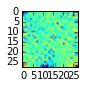

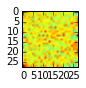

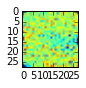

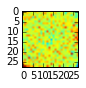

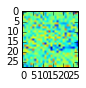

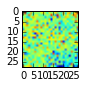

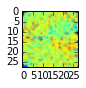

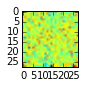

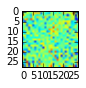

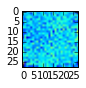

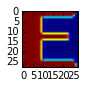

In [32]:
#extraction test data
test_1 = tf_test_dataset.eval()
ind = 11
onepic = test_1[ind,:]

#xtracting weights and biases
ws = weights.eval()
res = np.ndarray(shape=(image_size*image_size,num_labels), dtype=np.float32)
bs = np.ndarray(shape=(image_size*image_size,num_labels), dtype=np.float32)
i = 0
bs_1 = biases.eval()

#that's what is interesting: you can see letters forms, just printing out coefs in image form
for i in range(10):
    bs[:,i] = bs_1[i]
    res[:,i] = ws[:,i]+bs[:,i]  
    img = res[:,i]
    img=img.reshape((-1,28))
    plt.figure(figsize=(1,1),frameon=False)
    plt.imshow(img)

#that is matmul, not so promising
#for i in range(10):
#    bs[:,i] = bs_1[i]
#    res[:,i] = onepic*ws[:,i]+bs[:,i]  
#    img = res[:,i]
#    img=img.reshape((-1,28))
#    plt.figure(figsize=(1,1),frameon=False)
#    plt.imshow(img)

#printing out our pic
onepic = onepic.reshape((-1,28))
plt.figure(figsize=(1,1),frameon=False)
plt.imshow(onepic)

#printing out logit's for current ind
logit_1 = tf.matmul(tf_test_dataset, weights) + biases
l1 = logit_1.eval()
print l1[ind,:]

---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units (nn.relu()) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---

In [23]:
batch_size = 128

num_hid = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  #hidden layer
  w_hid = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hid]))
  b_hid = tf.Variable(tf.zeros([num_hid]))
  #output layer  
  weights = tf.Variable(
    tf.truncated_normal([num_hid, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  out_hid = tf.nn.relu(tf.matmul(tf_train_dataset, w_hid) + b_hid)
  logits = tf.matmul(out_hid, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  v_out_hid = tf.nn.relu(tf.matmul(tf_valid_dataset, w_hid) + b_hid)
  v_logits = tf.matmul(v_out_hid, weights) + biases
  valid_prediction = tf.nn.softmax(v_logits)
  t_out_hid = tf.nn.relu(tf.matmul(tf_test_dataset, w_hid) + b_hid)
  t_logits = tf.matmul(t_out_hid, weights) + biases  
  test_prediction = tf.nn.softmax(t_logits)

In [24]:
num_steps = 20001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print "Initialized"
  for step in xrange(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print "Minibatch loss at step", step, ":", l
      print "Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels)
      print "Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels)
  print "Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels)

Initialized
Minibatch loss at step 0 : 346.467
Minibatch accuracy: 13.3%
Validation accuracy: 37.1%
Minibatch loss at step 500 : 13.6819
Minibatch accuracy: 80.5%
Validation accuracy: 79.3%
Minibatch loss at step 1000 : 4.00732
Minibatch accuracy: 85.2%
Validation accuracy: 81.4%
Minibatch loss at step 1500 : 3.4808
Minibatch accuracy: 85.2%
Validation accuracy: 81.3%
Minibatch loss at step 2000 : 3.88899
Minibatch accuracy: 84.4%
Validation accuracy: 80.9%
Minibatch loss at step 2500 : 7.97296
Minibatch accuracy: 82.0%
Validation accuracy: 81.5%
Minibatch loss at step 3000 : 3.74366
Minibatch accuracy: 75.0%
Validation accuracy: 82.1%
Minibatch loss at step 3500 : 2.93965
Minibatch accuracy: 81.2%
Validation accuracy: 82.0%
Minibatch loss at step 4000 : 1.07259
Minibatch accuracy: 86.7%
Validation accuracy: 82.8%
Minibatch loss at step 4500 : 3.33373
Minibatch accuracy: 82.8%
Validation accuracy: 82.6%
Minibatch loss at step 5000 : 3.12787
Minibatch accuracy: 83.6%
Validation accuracy

With no hidden layers and 5000 steps, i get 87.0 % on test data/
With 1 hidden layer with 1024 relu's and 5000 steps, i got 89.0 % on test data.
Hm...
I got 89.0% with no hidden layers with 20000 steps.
And 91.8% with 1 hidden layer and 20000 steps.
Seems, there is some space to fit both these nets more.